# 통합 데이터 surprise로 돌리는 파일

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from surprise import Dataset 
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score,classification_report

In [2]:
import pandas as pd
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split

ratings = pd.read_csv('r.csv')
ratings = ratings[['user_id','product_id','rating']]
ratings = ratings.astype('int')
ratings['rating'] *= 1/3


# rating_0=ratings[ratings['rating']==0].index
# ratings=ratings.drop(rating_0)

ratings['rating'].value_counts()

0.333333    25519
0.666667    19915
1.000000      282
Name: rating, dtype: int64

In [3]:
ratings.to_csv('scaled_r.csv')

In [417]:
# scaler = MinMaxScaler()
# scaled = scaler.fit_transform(ratings['rating'].values.reshape(-1,1))
# ratings.insert(0, 'scaled', scaled)
# ratings.drop(['rating'], axis=1, inplace=True)
# ratings=ratings[["user_id",'product_id','scaled']]
# ratings.rename(columns={'scaled':'rating'}, inplace=True)
# ratings

In [4]:
reader = Reader(rating_scale=(0.0, 1.0))

# load_from_df사용해서 데이터프레임을 데이터셋으로 로드
# 인자에 userid-itemid-ratings 변수들이 포함된 데이터프레임형태로 넣어주면 됨!
data = Dataset.load_from_df(ratings[['user_id','product_id','rating']],
                           reader=reader)
train, test = train_test_split(data, test_size=0.25, random_state=42)

In [5]:
ratings['rating'].value_counts()

0.333333    25519
0.666667    19915
1.000000      282
Name: rating, dtype: int64

In [6]:
from surprise import SVD
algo = SVD()
algo.fit(train)

In [7]:
prediction = algo.test(test)
print('prediction type: ', type(prediction),
     'size: ', len(prediction))
print()
print('prediction 결과값 5개 미리보기')
print(prediction[:5])

prediction type:  <class 'list'> size:  11429

prediction 결과값 5개 미리보기
[Prediction(uid=20160, iid=86, r_ui=0.6666666666666666, est=0.6443042671403483, details={'was_impossible': False}), Prediction(uid=76604, iid=684, r_ui=0.3333333333333333, est=0.4647043677575259, details={'was_impossible': False}), Prediction(uid=96692, iid=155, r_ui=0.3333333333333333, est=0.5939496969168802, details={'was_impossible': False}), Prediction(uid=104028, iid=1371, r_ui=0.3333333333333333, est=0.5628027813070954, details={'was_impossible': False}), Prediction(uid=91839, iid=490, r_ui=0.3333333333333333, est=0.40415950748862384, details={'was_impossible': False})]


In [8]:
# user id, item id, 예측평점값들만 추출해서 하나의 튜플로 담겨있도록 하기
result = [(pred.uid, pred.iid, pred.est) for pred in prediction[:5]]
print(result)

[(20160, 86, 0.6443042671403483), (76604, 684, 0.4647043677575259), (96692, 155, 0.5939496969168802), (104028, 1371, 0.5628027813070954), (91839, 490, 0.40415950748862384)]


In [9]:
# 개별 데이터에 대한 예측값 반환을 위해서 predict() 사용
# user id, item id는 문자열로 되어있기 때문에 문자열로 넣어주어야 함!
uid = str(79)
iid = str(3)
# 변수 순서 지켜주어서 넣어주어야 함!
pred = algo.predict(uid, iid)
print(pred)

user: 79         item: 3          r_ui = None   est = 0.48   {'was_impossible': False}


In [10]:
predictions = algo.test(test)
accuracy.rmse(predictions)

RMSE: 0.1529


0.15289881488761656

In [11]:
from surprise.model_selection import cross_validate

algo = SVD(n_factors=50, random_state=42)
# cross_validate에는 파라미터를 입력시켜 놓은 모델을 인자로 넣어주자!
cross_validate(algo, data, measures=['RMSE','MAE'], cv=5,
              verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.1465  0.1463  0.1467  0.1467  0.1473  0.1467  0.0003  
MAE (testset)     0.1208  0.1214  0.1218  0.1209  0.1209  0.1211  0.0004  
Fit time          0.73    0.74    0.75    0.75    0.75    0.74    0.01    
Test time         0.06    0.02    0.02    0.06    0.03    0.04    0.02    


{'test_rmse': array([0.1465231 , 0.14634635, 0.14672057, 0.14666725, 0.14726632]),
 'test_mae': array([0.12083104, 0.1214034 , 0.12176132, 0.12086041, 0.12085193]),
 'fit_time': (0.7312629222869873,
  0.7425968647003174,
  0.7486059665679932,
  0.7527999877929688,
  0.7467079162597656),
 'test_time': (0.06352996826171875,
  0.02398395538330078,
  0.024463891983032227,
  0.06319427490234375,
  0.02537703514099121)}

/Users/duduuman/miniforge3/envs/tf/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Total number of ratings')

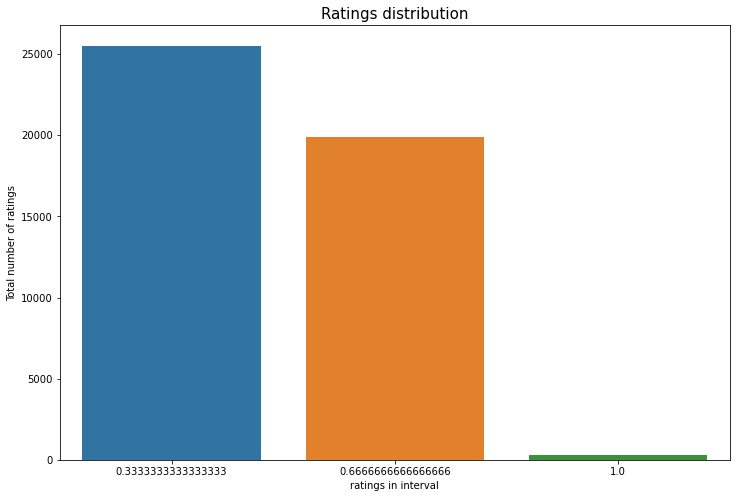

In [12]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Ratings distribution', fontsize=15)
sns.countplot(ratings['rating'])
ax.set_xlabel("ratings in interval")
ax.set_ylabel("Total number of ratings")

In [13]:
print("Size of trainset: ", train.n_ratings)
print("Size of testset: ", len(test))

Size of trainset:  34287
Size of testset:  11429


In [428]:
# from surprise import BaselineOnly

In [429]:
# baseline_model = BaselineOnly(verbose = False)
# baseline_model.fit(train)

In [430]:
# train_predictions = baseline_model.test(train.build_testset())
# test_predictions = baseline_model.test(test)
# print("RMSE on training data : ", accuracy.rmse(train_predictions,verbose = False))
# print("RMSE on test data: ", accuracy.rmse(test_predictions,verbose = False))

RMSE on training data :  0.13312259229339723
RMSE on test data:  0.14153040999036107


# KNNWithMeans

In [17]:
from surprise import KNNWithMeans
knn_model = KNNWithMeans(random_state = 42,verbose = False)
knn_model.fit(train)

In [18]:
train_predictions = knn_model.test(train.build_testset())
test_predictions = knn_model.test(test)
print("RMSE on training data : ", accuracy.rmse(train_predictions, verbose = False))
print("RMSE on test data: ", accuracy.rmse(test_predictions, verbose = False))

RMSE on training data :  0.0938207349570537
RMSE on test data:  0.15374585729708198


In [19]:
param_grid = {'k': list(range(10,45,5)),
             'min_k' : list(range(5,11))}
gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], return_train_measures = True, cv = 5)
gs.fit(data)
gs.best_params['rmse']

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

{'k': 40, 'min_k': 8}

In [65]:
tuned_knn_model = KNNWithMeans(k = 40, min_k= 8,random_state = 42, user_based = True, verbose = False)
tuned_knn_model.fit(train)
train_predictions = tuned_knn_model.test(train.build_testset())
test_predictions = tuned_knn_model.test(test)
print("RMSE on training data : ", accuracy.rmse(train_predictions, verbose = False))
print("RMSE on test data: ", accuracy.rmse(test_predictions, verbose = False))

print("RMSE on training data : ", accuracy.mae(train_predictions, verbose = False))
print("RMSE on test data: ", accuracy.mae(test_predictions, verbose = False))

RMSE on training data :  0.09608892220489698
RMSE on test data:  0.15010932162080318
RMSE on training data :  0.07395332487755163
RMSE on test data:  0.11779968015325377


In [66]:
knn_model_item_based = KNNWithMeans(k = 40, min_k= 8, user_based = False, random_state = 42)
knn_model_item_based.fit(train)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [67]:
train_predictions = knn_model_item_based.test(train.build_testset())
test_predictions = knn_model_item_based.test(test)
print("RMSE on training data : ", accuracy.rmse(train_predictions, verbose = False))
print("RMSE on test data: ", accuracy.rmse(test_predictions, verbose = False))

print("RMSE on training data : ", accuracy.mae(train_predictions, verbose = False))
print("RMSE on test data: ", accuracy.mae(test_predictions, verbose = False))

RMSE on training data :  0.09608892220489698
RMSE on test data:  0.15010932162080318
RMSE on training data :  0.07395332487755163
RMSE on test data:  0.11779968015325377


# KNNWithZScore

In [68]:
from surprise import KNNWithZScore
knn_model = KNNWithZScore(random_state = 42,verbose = False)
knn_model.fit(train)

In [69]:
train_predictions = knn_model.test(train.build_testset())
test_predictions = knn_model.test(test)
print("RMSE on training data : ", accuracy.rmse(train_predictions, verbose = False))
print("RMSE on test data: ", accuracy.rmse(test_predictions, verbose = False))

RMSE on training data :  0.09406491064236136
RMSE on test data:  0.1548072715552096


In [26]:
param_grid = {'k': list(range(10,45,5)),
             'min_k' : list(range(5,11))}
gs = GridSearchCV(KNNWithZScore, param_grid, measures=['rmse'], return_train_measures = True, cv = 5)
gs.fit(data)
gs.best_params['rmse']

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

{'k': 40, 'min_k': 7}

In [70]:
tuned_knn_model = KNNWithZScore(k = 40, min_k= 7,random_state = 42, verbose = False)
tuned_knn_model.fit(train)
train_predictions = tuned_knn_model.test(train.build_testset())
test_predictions = tuned_knn_model.test(test)
print("RMSE on training data : ", accuracy.rmse(train_predictions, verbose = False))
print("RMSE on test data: ", accuracy.rmse(test_predictions, verbose = False))

print("RMSE on training data : ", accuracy.mae(train_predictions, verbose = False))
print("RMSE on test data: ", accuracy.mae(test_predictions, verbose = False))

RMSE on training data :  0.09611198255968346
RMSE on test data:  0.1505453824634947
RMSE on training data :  0.07336211446006236
RMSE on test data:  0.1179712205363957


In [71]:
knn_model_item_based = KNNWithZScore(k = 40, min_k= 7, user_based = False, random_state = 42)
knn_model_item_based.fit(train)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [72]:
train_predictions = knn_model_item_based.test(train.build_testset())
test_predictions = knn_model_item_based.test(test)
print("RMSE on training data : ", accuracy.rmse(train_predictions, verbose = False))
print("RMSE on test data: ", accuracy.rmse(test_predictions, verbose = False))

print("RMSE on training data : ", accuracy.mae(train_predictions, verbose = False))
print("RMSE on test data: ", accuracy.mae(test_predictions, verbose = False))

RMSE on training data :  0.09611198255968346
RMSE on test data:  0.1505453824634947
RMSE on training data :  0.07336211446006236
RMSE on test data:  0.1179712205363957


# SVD

In [73]:
svd_model = SVD(random_state = 42)
svd_model.fit(train)

In [39]:
train_predictions = svd_model.test(train.build_testset())
test_predictions = svd_model.test(test)
print("RMSE on training data : ", accuracy.rmse(train_predictions, verbose = False))
print("RMSE on test data: ", accuracy.rmse(test_predictions, verbose = False))

RMSE on training data :  0.12379361886798121
RMSE on test data:  0.15493124334268454


In [41]:
param_distributions  = {'n_factors': list(range(50,160,10)),'reg_all': np.arange(0.01,0.2,0.02),'n_epochs' : list(range(1,51))}
rs = RandomizedSearchCV(SVD, param_distributions, measures=['rmse'], return_train_measures = True, cv = 5, n_iter = 20)
rs.fit(data)
rs.best_params['rmse']

{'n_factors': 80, 'reg_all': 0.10999999999999997, 'n_epochs': 40}

In [74]:
tuned_svd_model = SVD(n_factors=80, reg_all =0.109, n_epochs = 40, random_state = 42,verbose = False)
tuned_svd_model.fit(train)
train_predictions = tuned_svd_model.test(train.build_testset())
test_predictions = tuned_svd_model.test(test)
print("RMSE on training data : ", accuracy.rmse(train_predictions, verbose = False))
print("RMSE on test data: ", accuracy.rmse(test_predictions, verbose = False))

print("RMSE on training data : ", accuracy.mae(train_predictions, verbose = False))
print("RMSE on test data: ", accuracy.mae(test_predictions, verbose = False))

RMSE on training data :  0.11437254697394039
RMSE on test data:  0.13958519208289977
RMSE on training data :  0.09445669746572102
RMSE on test data:  0.11666605828147424


# SVDpp

In [44]:
from surprise import SVDpp

In [75]:
svd_model = SVDpp(random_state = 42)
svd_model.fit(train)

In [49]:
train_predictions = svd_model.test(train.build_testset())
test_predictions = svd_model.test(test)
print("RMSE on training data : ", accuracy.rmse(train_predictions, verbose = False))
print("RMSE on test data: ", accuracy.rmse(test_predictions, verbose = False))

RMSE on training data :  0.12121853764602866
RMSE on test data:  0.14144943666794826


In [50]:
param_distributions  = {'n_factors': list(range(50,160,10)),'reg_all': np.arange(0.01,0.2,0.02),'n_epochs' : list(range(1,51))}
rs = RandomizedSearchCV(SVDpp, param_distributions, measures=['rmse'], return_train_measures = True, cv = 5, n_iter = 20)
rs.fit(data)
rs.best_params['rmse']

{'n_factors': 50, 'reg_all': 0.15, 'n_epochs': 43}

In [76]:
tuned_svd_model = SVDpp(n_factors=50, reg_all =0.15, n_epochs = 43, random_state = 42,verbose = False)
tuned_svd_model.fit(train)
train_predictions = tuned_svd_model.test(train.build_testset())
test_predictions = tuned_svd_model.test(test)
print("RMSE on training data : ", accuracy.rmse(train_predictions, verbose = False))
print("RMSE on test data: ", accuracy.rmse(test_predictions, verbose = False))

print("RMSE on training data : ", accuracy.mae(train_predictions, verbose = False))
print("RMSE on test data: ", accuracy.mae(test_predictions, verbose = False))

RMSE on training data :  0.11359161702141227
RMSE on test data:  0.13700862030865602
RMSE on training data :  0.09336124422995537
RMSE on test data:  0.11436906080928257


# NMF

In [52]:
from surprise import NMF

In [77]:
nmf_model = NMF(random_state = 42)
nmf_model.fit(train)

In [54]:
train_predictions = nmf_model.test(train.build_testset())
test_predictions = nmf_model.test(test)
print("RMSE on training data : ", accuracy.rmse(train_predictions, verbose = False))
print("RMSE on test data: ", accuracy.rmse(test_predictions, verbose = False))

RMSE on training data :  0.11496310871867792
RMSE on test data:  0.15535892509168164


In [55]:
train_predictions[:5]

[Prediction(uid=96611, iid=1418, r_ui=0.6666666666666666, est=0.5161668228763133, details={'was_impossible': False}),
 Prediction(uid=96611, iid=1572, r_ui=0.3333333333333333, est=0.47253945280903087, details={'was_impossible': False}),
 Prediction(uid=96611, iid=77, r_ui=0.6666666666666666, est=0.5146272078212113, details={'was_impossible': False}),
 Prediction(uid=96611, iid=184, r_ui=0.6666666666666666, est=0.5109283142518389, details={'was_impossible': False}),
 Prediction(uid=96611, iid=216, r_ui=0.6666666666666666, est=0.5179924528531888, details={'was_impossible': False})]

In [56]:
param_distributions  = {'n_factors': list(range(10,20,2)),'reg_pu': np.arange(0.01,0.2,0.01),'reg_qi': np.arange(0.01,0.2,0.01), 'n_epochs' : list(range(1,51))}
rs = RandomizedSearchCV(NMF, param_distributions, measures=['rmse'], return_train_measures = True, cv = 5, n_iter = 20)
rs.fit(data)
rs.best_params['rmse']

{'n_factors': 14, 'reg_pu': 0.14, 'reg_qi': 0.02, 'n_epochs': 8}

In [78]:
#tuned_nmf_model = NMF(n_factors=18, reg_pu = 0.06, reg_qi = 0.16, n_epochs = 38, random_state = 42)
tuned_nmf_model = NMF(n_factors=14, reg_pu=0.14, reg_qi= 0.02, n_epochs=8, random_state = 42)
tuned_nmf_model.fit(train)
train_predictions = tuned_nmf_model.test(train.build_testset())
test_predictions = tuned_nmf_model.test(test)
print("RMSE on training data : ", accuracy.rmse(train_predictions, verbose = False))
print("RMSE on test data: ", accuracy.rmse(test_predictions, verbose = False))

print("RMSE on training data : ", accuracy.mae(train_predictions, verbose = False))
print("RMSE on test data: ", accuracy.mae(test_predictions, verbose = False))

RMSE on training data :  0.09765073978952016
RMSE on test data:  0.14780088519387566
RMSE on training data :  0.0706785107106911
RMSE on test data:  0.11813059971331104


# precision recall metric

In [446]:
userIds = []
productIds = []
ratings = []
for (uid, iid, rating) in train.all_ratings():
    userIds.append(train.to_raw_uid(uid))
    productIds.append(train.to_raw_iid(iid))
    ratings.append(rating)
dict = {'userId': userIds, 'productIds': productIds, 'rating': ratings}
training_df = pd.DataFrame(dict)

In [447]:
user_averages = training_df.groupby("userId")["rating"].mean()
user_averages

userId
0         0.666667
4         0.460317
43        0.666667
48        0.500000
139       0.333333
            ...   
124574    0.333333
124586    0.666667
124588    0.666667
124594    0.666667
124616    0.500000
Name: rating, Length: 10745, dtype: float64

In [448]:
train_actual_labels = []
train_predicted_labels = []
for uid, iid, r_ui, est, _ in train_predictions:
    if((r_ui - user_averages[uid])>0):
        train_actual_labels.append("Yes")
    else:
        train_actual_labels.append("No")
    if((est - user_averages[uid])>0):
        train_predicted_labels.append("Yes")
    else:
        train_predicted_labels.append("No")

In [449]:
print("Training data distribution of liked movies derived from actual ratings")
print(pd.Series(train_actual_labels).value_counts())
print("\nTraining data distribution of liked movies derived from predicted ratings")
print(pd.Series(train_predicted_labels).value_counts())

Training data distribution of liked movies derived from actual ratings
No     23415
Yes    10872
dtype: int64

Training data distribution of liked movies derived from predicted ratings
No     22256
Yes    12031
dtype: int64


In [450]:
user_averages = training_df.groupby("userId")["rating"].mean()
user_averages

userId
0         0.666667
4         0.460317
43        0.666667
48        0.500000
139       0.333333
            ...   
124574    0.333333
124586    0.666667
124588    0.666667
124594    0.666667
124616    0.500000
Name: rating, Length: 10745, dtype: float64

In [451]:
# test

In [452]:
test_actual_labels = []
test_predicted_labels = []

for uid, iid, r_ui, est, _ in test_predictions:
    if uid in user_averages: 
        if((r_ui - user_averages[uid])>0):
            test_actual_labels.append("Yes")
        else:
            test_actual_labels.append("No")
        if((est - user_averages[uid])>0):
            test_predicted_labels.append("Yes")
        else:
            test_predicted_labels.append("No") 

In [453]:
print("Test data distribution of liked movies derived from actual ratings")
print(pd.Series(test_actual_labels).value_counts())
print("\nTest data distribution of liked movies derived from predicted ratings")
print(pd.Series(test_predicted_labels).value_counts())

Test data distribution of liked movies derived from actual ratings
No     5944
Yes    3643
dtype: int64

Test data distribution of liked movies derived from predicted ratings
No     6495
Yes    3092
dtype: int64


In [454]:
print("Confusion matrix on test data")
confusion_matrix(test_actual_labels,test_predicted_labels)

Confusion matrix on test data


array([[4708, 1236],
       [1787, 1856]])

In [455]:
print("Training data precision : ", precision_score(train_actual_labels,train_predicted_labels,pos_label="Yes"))
print("Test data precision : ", precision_score(test_actual_labels,test_predicted_labels,pos_label="Yes"))

Training data precision :  0.7407530546089269
Test data precision :  0.6002587322121604


In [456]:
print("Training data recall : ", recall_score(train_actual_labels,train_predicted_labels,pos_label="Yes"))
print("Test data recall : ", recall_score(test_actual_labels,test_predicted_labels,pos_label="Yes"))

Training data recall :  0.8197203826342899
Test data recall :  0.509470216854241


In [457]:
print("="*20, "Classification Report", "="*20)
print(classification_report(test_actual_labels,test_predicted_labels))

==================== Classification Report ====================
              precision    recall  f1-score   support

          No       0.72      0.79      0.76      5944
         Yes       0.60      0.51      0.55      3643

    accuracy                           0.68      9587
   macro avg       0.66      0.65      0.65      9587
weighted avg       0.68      0.68      0.68      9587

